In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from phonopy import Phonopy
import phonopy.interface.vasp as Intf_vasp
from phonopy.structure.atoms import PhonopyAtoms
import phonopy.file_IO as PhonIO
from phonopy.interface.calculator import get_default_physical_units
import API_quippy_phonopy_VASP as api_qpv # remember to set this module to python path
import copy as cp
from phonopy.interface.alm import get_fc2

In [2]:
Temperatures= [300] #[10,50,100,150,200,300]
NSnaps = 50
Niter = 1 # number of iterations
if_write_iter = False
gp_xml_file= "../Dielectric_function_NaCl/soap_n12l11_6.0cut_coul/gp_NaCl_soap_coul.xml"
Qpoints=np.array([[0.0001,0.0001,1.0],[0.5,0.5,1.0],[3./8,3./8,3./4],[0.0,0.0,0.0],[0.5,0.5,0.5]])
band_labels=['$\Gamma$','X','K','$\Gamma$','L']
#Qpoints = np.array([[0.5,0.0,0.0],[0,0,0],[2./3,1./3,0.0]])
#band_labels = ['M','$\Gamma$','K']
Ncells=[4,4,4]
Band_points=51
NAC = True
interface_mode = 'vasp'

Unit_cell = Intf_vasp.read_vasp("POSCAR") # read prim cell from the POSCAR file
prim_mat = np.eye(3)#[[0, 0.5, 0.5],[0.5, 0, 0.5],[0.5, 0.5, 0]]

In [3]:
# Obtain Eigenvectors using Finite Displace
phonon = Phonopy(Unit_cell,np.diag(Ncells),primitive_matrix=prim_mat)
phonon_scell = Phonopy(phonon.get_supercell(),np.eye(3),primitive_matrix=prim_mat) # generate an phononpy object for LD calc.
phonon_scell.generate_displacements(distance=0.03) # vasp
Scells_phonopy = phonon_scell.get_supercells_with_displacements() # This returns a list of Phononpy atoms object

In [4]:
Scells_quippy=[]
for scell in Scells_phonopy:
    Scells_quippy.append(api_qpv.phonopyAtoms_to_aseAtoms(scell))

In [5]:
force_quip_scells = api_qpv.calc_force_sets_GAP(gp_xml_file,Scells_quippy)

#parse force set and calc force constants
phonon_scell.set_forces(force_quip_scells)
PhonIO.write_FORCE_SETS(phonon_scell.get_displacement_dataset()) # write forces & displacements to FORCE_SET
force_set=PhonIO.parse_FORCE_SETS() # parse force_sets
phonon_scell.set_displacement_dataset(force_set) # force_set is a list of forces and displacements


phonon_scell.produce_force_constants()
phonon_scell.symmetrize_force_constants()

if NAC == True:
    nac_params_sc = PhonIO.get_born_parameters(open("BORN"), 
                                                phonon_scell.get_primitive(),
                                                phonon_scell.get_primitive_symmetry())
    if nac_params_sc['factor'] == None:
        physical_units = get_default_physical_units(interface_mode)
        nac_params_sc['factor'] = physical_units['nac_factor']
    phonon_scell._nac_params = nac_params_sc
    
phonon_scell._set_dynamical_matrix()
DynMat0 = phonon_scell._dynamical_matrix.get_dynamical_matrix()
bands_sc=api_qpv.qpoints_Band_paths([[0.0,0.0,0.0]],1) #supercell
phonon_scell.set_band_structure(bands_sc, is_eigenvectors=True)
phonon_scell.set_mesh([1,1,1], is_eigenvectors=True)

#eigvecs=api_qpv.get_reshaped_eigvecs(phonon_scell) # zero-th iteration, eigenvectors from finite displacement




--------------------------------- ALM start --------------------------------
ALM is a non-trivial force constants calculator. Please cite the paper:
T. Tadano and S. Tsuneyuki, J. Phys. Soc. Jpn. 87, 041015 (2018).
ALM is developed at https://github.com/ttadano/ALM by T. Tadano.
Increase log-level to watch detailed ALM log.
---------------------------------- ALM end ---------------------------------


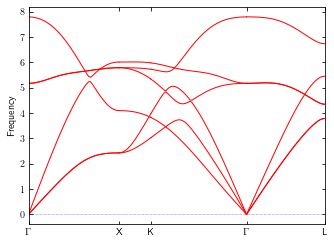

In [6]:
# Generate thermal displacements along eigenvectors, i.e. populate phonon modes.

for Temperature in Temperatures:
    FCSum = np.zeros(phonon_scell.get_force_constants().shape)
    FCave = np.zeros(FCSum.shape)
    for icalc in range(Niter):
        u_disps = api_qpv.thermo_disp_along_eig(phonon_scell,Temperature,NSnaps)
        Scell_snaps = [];
        Supercell = phonon_scell.get_supercell()
        Intf_vasp.write_vasp("SPOSCAR_NaCl",Supercell)
        pos0 = Supercell.get_positions()
        
        snaps_ase=[]
        for isnap in range(NSnaps):
            Scell_tmp = cp.deepcopy(Supercell)
            pos = pos0 + u_disps[isnap]
            Scell_tmp.set_positions(pos)
            Scell_snaps.append(Scell_tmp)
            snaps_ase.append(api_qpv.phonopyAtoms_to_aseAtoms(Scell_tmp))
        
        displacements,forces=api_qpv.get_DFSETS(Supercell,Scell_snaps,gp_xml_file)
        FC2=get_fc2(Supercell,phonon.get_primitive(),displacements,forces,log_level=1)
        FCSum = FCSum + FC2
        FCave = FCSum/(icalc+1)
        phonon_scell.set_force_constants(FCave) # average.
        bands_sc=api_qpv.qpoints_Band_paths([[0.0,0.0,0.0]],1) #supercell
        phonon_scell.set_band_structure(bands_sc, is_eigenvectors=True)
        phonon_scell.set_mesh([1,1,1], is_eigenvectors=True)
        
        phonon.set_force_constants(FCave)
        phonon.symmetrize_force_constants()
        
        
        if NAC == True:
            nac_params = PhonIO.get_born_parameters(open("BORN"), 
                                                    phonon.get_primitive(),
                                                    phonon.get_primitive_symmetry())
            nac_params_sc = PhonIO.get_born_parameters(open("BORN"), 
                                                    phonon_scell.get_primitive(),
                                                    phonon_scell.get_primitive_symmetry())
                
            if nac_params['factor'] == None:
                physical_units = get_default_physical_units(interface_mode)
                nac_params['factor'] = physical_units['nac_factor']
            if nac_params_sc['factor'] == None:
                nac_params_sc['factor'] = physical_units['nac_factor']
            phonon._nac_params = nac_params
            phonon_scell._nac_params = nac_params_sc
            phonon._set_dynamical_matrix()
            phonon_scell._set_dynamical_matrix()
        
        if if_write_iter:
            bands=api_qpv.qpoints_Band_paths(Qpoints,Band_points)
            phonon.set_band_structure(bands,labels=band_labels)
            bs_plt=phonon.plot_band_structure()
            phonon.write_yaml_band_structure(filename='NaCl_disp_'+str(Temperature)+'K_iter'+str(icalc+1)+'.yaml')

    
    PhonIO.write_FORCE_CONSTANTS(phonon.get_force_constants(), filename='FORCE_CONSTANTS_'+str(Temperature)+'K')
    bands=api_qpv.qpoints_Band_paths(Qpoints,Band_points)
    phonon.set_band_structure(bands,labels=band_labels)
    bs_plt=phonon.plot_band_structure()
    phonon.write_yaml_band_structure(filename='NaCl_disp_'+str(Temperature)+'K.yaml')

In [7]:
import API_alamode as api_alm

In [ ]:
ifc2,ifc3 = api_alm.get_fc2_fc3(Supercell,phonon.get_primitive(),displacements,forces,log_level=1)

--------------------------------- ALM start --------------------------------
ALM is a non-trivial force constants calculator. Please cite the paper:
T. Tadano and S. Tsuneyuki, J. Phys. Soc. Jpn. 87, 041015 (2018).
ALM is developed at https://github.com/ttadano/ALM by T. Tadano.
Increase log-level to watch detailed ALM log.
